In [104]:
from pathlib import Path
from kilosort.io import load_ops
import sys
import spikeinterface as si
import matplotlib.pyplot as plt

import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from kilosort import io
warnings.filterwarnings('ignore')

global_job_kwargs = dict(n_jobs = 4)
si.set_global_job_kwargs(**global_job_kwargs)

In [105]:
import os
import pandas as pd
import numpy as np

def get_spike_inf(file_path):
    cluster_inf = pd.read_csv(file_path + "/analyzer_kilosort4_binary/extensions/quality_metrics/metrics.csv")
    cluster_inf.columns = ['cluster', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
                           'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
                           'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
                           'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
                           'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
                           'drift_ptp', 'drift_std', 'drift_mad', 'sd_ratio']
    
    cluster_inf['cluster'] = cluster_inf['cluster'].astype(str)
    cluster_inf['position_1'] = None
    cluster_inf['position_2'] = None

    spike_clusters = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_clusters.npy").astype(str))
    spike_positions = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_positions.npy").astype(float))
    spike_templates = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_templates.npy"))
    spike_times = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_times.npy").astype(int))
    tf = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/tF.npy")[:, 0, :])

    spike_inf = pd.concat((spike_clusters, spike_positions, spike_templates, spike_times, tf), axis=1)
    spike_inf.columns = ['cluster', 'position_1', 'position_2', 'templates', 'time', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

    for i in spike_inf['cluster'].value_counts().index:
        temp = spike_inf[spike_inf['cluster'] == i]
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_1'] = np.mean(temp['position_1'])
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_2'] = np.mean(temp['position_2'])

    cluster_inf['probe_group'] = "1"

    for i in spike_inf['cluster'].value_counts().index:
        cluster_rows = cluster_inf[cluster_inf['cluster'] == i]
        if (cluster_rows['position_1'] > 100).any() and (cluster_rows['position_1'] < 250).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "2"
        elif (cluster_rows['position_1'] > 250).any() and (cluster_rows['position_1'] < 400).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "3"
        elif (cluster_rows['position_1'] > 400).any() and (cluster_rows['position_1'] < 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "4"
        elif (cluster_rows['position_1'] > 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "5"

    waveform = np.load(file_path + "/kilosort4/sorter_output/templates.npy")
    cluster_inf['waveform'] = [waveform[i] for i in range(waveform.shape[0])]

    cluster_inf = cluster_inf[((cluster_inf['snr'] > 3) & (cluster_inf['num_spikes'] > int(5000))) | ((cluster_inf['snr'] < 3) & (cluster_inf['num_spikes'] > 8000))]
    spike_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_inf['cluster']))]
    spike_inf = spike_inf[spike_inf['time'] > 200]
    cluster_inf['date'] = date
    spike_inf['date'] = date
    
    channel_indices = {
        "1": [1, 3, 5, 6, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10, 12]
        }

    for index, row in cluster_inf.iterrows():
        probe_group = row['probe_group']
        if probe_group in channel_indices:
            selected_channels = channel_indices[probe_group]
            cluster_inf.at[index, 'waveform'] = row['waveform'][:, selected_channels]

    return cluster_inf, spike_inf

all_cluster_inf = pd.DataFrame()
all_spike_inf = pd.DataFrame()

for date in os.listdir("/media/ubuntu/sda/data/sort_output/mouse6/natural_image"):
    cluster_inf, spike_inf = get_spike_inf(file_path=f"/media/ubuntu/sda/data/sort_output/mouse6/natural_image/{date}")
    all_cluster_inf = pd.concat([all_cluster_inf, cluster_inf], ignore_index=True)
    all_spike_inf = pd.concat([all_spike_inf, spike_inf], ignore_index=True)

In [106]:
channel_indices = {
        "1": [1, 3, 5, 6, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10, 12]
        }

channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]
}

In [107]:
def calculate_position(row):
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]
    waveform = row['waveform'] 
    
    a_squared = [np.sum(waveform[:, j]**2) for j in range(len(channels))]
    
    sum_x_a = 0
    sum_y_a = 0
    sum_a = 0
    
    for j, channel in enumerate(channels):
        x_i, y_i = channel_position.get(channel, [0, 0])  
        a_i_sq = a_squared[j]
        
        sum_x_a += x_i * a_i_sq
        sum_y_a += y_i * a_i_sq
        sum_a += a_i_sq
    
    if sum_a == 0:
        return pd.Series({'position_1': 0, 'position_2': 0})
    
    x_hat = sum_x_a / sum_a
    y_hat = sum_y_a / sum_a
    return pd.Series({'position_1': x_hat, 'position_2': y_hat})

all_cluster_inf[['position_1', 'position_2']] = all_cluster_inf.apply(calculate_position, axis=1)

In [108]:
all_cluster_inf['cluster_date'] = all_cluster_inf['date']  + "_" +  all_cluster_inf['cluster']
all_spike_inf['cluster_date'] = all_spike_inf['date']  + "_" +  all_spike_inf['cluster']

all_spike_inf = all_spike_inf[all_spike_inf['cluster_date'].isin(list(all_cluster_inf['cluster_date']))]

In [109]:
import numpy as np

def calculate_position_waveform(row, channel_position, channel_indices, power=2):
    x_target = row['position_1']
    y_target = row['position_2']
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]  
    waveforms = row['waveform']  
    
    distances = []
    for channel in channels:
        x_channel, y_channel = channel_position.get(channel, [np.nan, np.nan])
        if np.isnan(x_channel):  
            continue
        distance = np.sqrt((x_target - x_channel)**2 + (y_target - y_channel)**2)
        distances.append(distance)
    
    if not distances:  
        return np.zeros(61)
    
    #IDW
    weights = 1 / (np.array(distances) ** power)
    if np.any(distances == 0):
        zero_idx = np.argwhere(distances == 0).flatten()
        return waveforms[:, zero_idx[0]]
    
    weights /= np.sum(weights)
    
    synthesized_waveform = np.zeros(61)
    for t in range(61): 
        weighted_sum = np.dot(waveforms[t, :], weights)
        synthesized_waveform[t] = weighted_sum
    
    return synthesized_waveform

all_cluster_inf['position_waveform'] = all_cluster_inf.apply(
    calculate_position_waveform, 
    axis=1, 
    args=(channel_position, channel_indices, 2)  
)

In [110]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage,fcluster

df_expanded = all_cluster_inf['position_waveform'].apply(pd.Series)

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_expanded)

eps = 1
min_samples = 15

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(principal_components)

label = pd.DataFrame(dbscan.labels_, columns=['labels'])


<Axes: >

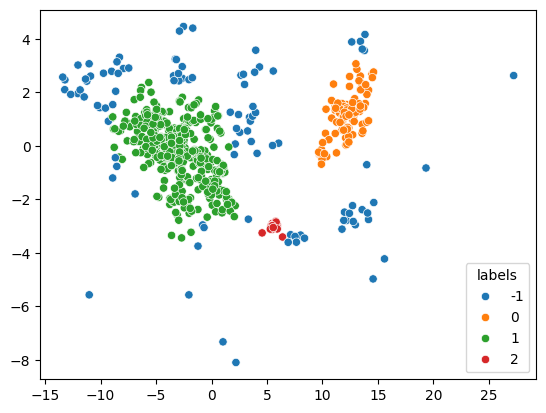

In [111]:
sns.scatterplot(x = principal_components[:, 0],
                y = principal_components[:, 1],
                hue=label.iloc[:, 0].astype(str))

In [112]:
label['cluster_date'] = all_cluster_inf['cluster_date']
label = label[label['labels'] != -1]

In [113]:
all_cluster_inf = all_cluster_inf[all_cluster_inf['cluster_date'].isin(label['cluster_date'].tolist())]

In [114]:
all_cluster_inf

,cluster,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,drift_std,drift_mad,sd_ratio,position_1,position_2,probe_group,waveform,date,cluster_date,position_waveform
1,2,6600,2.538452,1.000000,3.688485,0.994800,50,1.000000,25,NaN,...,1.033658,0.546125,1.902848,48.260650,41.346909,1,"[[0.0018782029, 0.0753184, 0.03509049, 0.0, 0....",031722,031722_2,"[0.20098703290470868, 0.27338950348770547, 0.3..."
2,3,41228,15.856862,1.000000,7.600758,0.421162,826,0.344681,373,0.160,...,0.505261,0.395295,1.568793,49.789079,2.055938,1,"[[0.0027666944, -0.027957989, 0.0076924865, 0....",031722,031722_3,"[-0.019775146629968272, 0.03227996141049755, 0..."
5,7,12161,4.677290,0.976744,3.168483,12.464724,2127,1.000000,1439,NaN,...,NaN,NaN,1.531610,648.750714,26.399489,5,"[[-0.10049891, -0.10302551, 0.016861722, 0.011...",031722,031722_7,"[-0.07499993640844507, -0.07685743234522417, -..."
6,8,42961,16.523398,1.000000,11.094223,0.095793,204,0.079973,109,0.025,...,0.255717,0.198309,1.433885,600.204848,1.459341,5,"[[-0.00073998654, -0.00038684625, 0.004340426,...",031722,031722_8,"[0.05004388217735483, 0.10274861583657988, 0.1..."
7,9,20341,7.823431,1.000000,14.844620,0.278587,133,0.326725,87,0.235,...,0.535444,0.322329,1.783094,599.996548,49.036891,5,"[[-0.003879247, 6.57253e-05, 0.0023588166, -0....",031722,031722_9,"[-0.013380605001445129, 0.050323543601109966, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,60,47573,19.567116,1.000000,8.620557,0.223806,625,0.131673,229,0.035,...,0.551651,0.394460,1.460179,348.649976,450.700548,3,"[[-0.006237936, 0.008668704, -0.02471589, -0.0...",042323,042323_60,"[-0.024618281450175538, 0.02809791579422065, 0..."
679,61,18155,7.467282,1.000000,5.548774,0.149986,61,0.164794,41,0.125,...,0.321365,0.175871,1.302286,349.144394,488.787551,3,"[[-0.0042212643, -0.0023049167, 0.048846297, 0...",042323,042323_61,"[0.06368307721399441, 0.08396160495722714, 0.1..."
680,62,13412,5.516452,1.000000,7.899877,0.428005,95,0.352842,43,0.130,...,0.322419,0.213996,1.133445,349.049628,497.082465,3,"[[0.0023381682, -0.0057021733, -0.03373424, -0...",042323,042323_62,"[-0.05351961050084173, -0.04114504109634896, -..."
681,63,9334,3.839141,1.000000,6.814251,0.437195,47,0.672881,32,NaN,...,0.390097,0.339963,1.214283,301.770489,499.347446,3,"[[0.006754703, 0.016550677, 0.0023240012, -0.0...",042323,042323_63,"[-0.06331247550906881, -0.04214182317470802, -..."


In [115]:
current_max_neuron = 1  
all_cluster_inf['Neuron'] = None
all_cluster_inf.index = range(len(all_cluster_inf))

for i in range(1, len(all_cluster_inf)):
    current_pos1 = all_cluster_inf.loc[i, 'position_1']
    current_pos2 = all_cluster_inf.loc[i, 'position_2']
    
    mask = (
        (all_cluster_inf.loc[:i-1, 'position_1'] - current_pos1).abs().lt(10) & 
        (all_cluster_inf.loc[:i-1, 'position_2'] - current_pos2).abs().lt(10)
    )
    
    matched = all_cluster_inf.loc[:i-1][mask]
    
    if not matched.empty:
        all_cluster_inf.at[i, 'Neuron'] = matched['Neuron'].iloc[-1]
    else:
        current_max_neuron += 1
        all_cluster_inf.at[i, 'Neuron'] = f'Neuron_{current_max_neuron}'

In [116]:
neuron_date = pd.crosstab(all_cluster_inf['Neuron'], all_cluster_inf['date'])   
neuron_date[neuron_date > 1] = 1
neuron_date = neuron_date.sum(axis=1)
neuron_date = neuron_date[neuron_date == 15]
neuron_date = neuron_date.index

In [117]:
len(neuron_date)

18

In [118]:
all_cluster_inf = all_cluster_inf[all_cluster_inf['Neuron'].isin(neuron_date)]

In [119]:
all_cluster_inf['neuron_date'] = all_cluster_inf['date'] + "_" + all_cluster_inf['Neuron']
#all_spike_inf['neuron_date'] = all_spike_inf['date'] + "_" + all_spike_inf['Neuron']

In [120]:
waveform_mean = pd.DataFrame()
csv_files = [f for f in os.listdir('/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/waveform') if f.startswith('waveform_mean_Neuron_') and f.endswith('.csv')]
for csv_file in csv_files:
    df = pd.read_csv(os.path.join('/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/waveform', csv_file), index_col=0)
    waveform_mean = pd.concat((waveform_mean, df), axis=0)

waveform_mean = waveform_mean.loc[list(all_cluster_inf['cluster_date'])]

In [121]:
all_cluster_inf = all_cluster_inf.set_index('cluster_date')
all_cluster_inf = all_cluster_inf.join(waveform_mean, how="right")

In [122]:
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import colorsys
from matplotlib.backends.backend_pdf import PdfPages

def generate_base_colors(n, saturation=0.6, lightness=0.5):
    hues = np.linspace(0, 1, n, endpoint=False)  
    base_colors = []
    for h in hues:
        rgb = colorsys.hls_to_rgb(h, lightness, saturation)
        base_colors.append(rgb)
    return base_colors

n_neurons = len(all_cluster_inf['Neuron'].unique())
base_palette = generate_base_colors(n_neurons) 


def get_gradient_palette(base_color, n_levels=16, reverse=False):
    palette = sns.light_palette(base_color, n_levels, reverse=reverse)
    return palette


with PdfPages('figure/cluster_view_test.pdf') as pdf:
    n_neurons = len(all_cluster_inf['Neuron'].unique())
    base_palette = generate_base_colors(n_neurons)
    
    for idx, neuron in enumerate(all_cluster_inf['Neuron'].unique()):
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        
        current_base_color = base_palette[idx]
        line_palette = get_gradient_palette(current_base_color, n_levels=25, reverse=False)
        
        fig, ax = plt.subplots(figsize=(1.5, 1.5))
        for i in range(15):
            sns.lineplot(
                x=range(32),
                y=temp.iloc[i, 41:73],
                color=line_palette[i + 6],  
                ax=ax
            )
        
        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        pdf.savefig(fig)
        plt.close(fig)

In [46]:
all_cluster_inf = all_cluster_inf[all_cluster_inf['Neuron'] != "Neuron_14"]
all_spike_inf = all_spike_inf[all_spike_inf['Neuron'] != "Neuron_14"]

In [47]:
all_cluster_inf.to_csv('/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/cluster_inf.tsv', sep = '\t')
all_spike_inf.to_csv("/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/spike_inf.tsv", sep='\t')

In [48]:
all_cluster_inf = pd.read_csv("cluster_inf.tsv", sep = '\t')

In [49]:
from matplotlib.backends.backend_pdf import PdfPages


In [50]:
with PdfPages('figure/waveform_channel.pdf') as pdf:
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#898989'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#55A5DB'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#753589'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()


ValueError: zero-dimensional arrays cannot be concatenated

<Figure size 1000x1000 with 0 Axes>